# AR Survey: Comparing Field Geometry and AIA Emission

In [21]:
import os
import io
import glob
import urllib
import datetime
import warnings
warnings.filterwarnings('ignore')

import pandas
import numpy as np
from sunpy.map import Map
from sunpy.net import Fido,attrs as a
from sunpy.time import TimeRange
import yt
import astropy.units as u
import astropy.constants as const
import astropy.table
from astropy.coordinates import SkyCoord
import synthesizAR
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import seaborn.apionly as sns

%matplotlib inline

We want to look at the geometry from PFSS field extrapolations of several different observed ARs and compare with the observed emission to see how well they reproduce the actual "loops." We will use the set of 15 ARs originally studied by Warren et al. (2012) and then later by Viall and Klimchuk (2017). We will perform a field extrapolation for each HMI magnetogram and then compare with the corresponding AIA 171 emission.

## AR Catalogue
First we need to pull down the table of AR data from the original Warren et al. (2012) paper. Convert all  of the times to datetimes and the locations to unitful quantities

In [2]:
tmp = (urllib.request.urlopen('http://iopscience.iop.org/0004-637X/759/2/141/suppdata/apj446760t1_ascii.txt')
                     .readlines())
col_names = tmp[3].decode('utf8').strip().split('\t')
raw_table = [t.decode('utf8').strip().split('\t') for t in tmp[4:-3]]
ar_catalogue = pandas.DataFrame(data=raw_table,columns=col_names)
ar_catalogue['Date'] = pandas.to_datetime(ar_catalogue['Date'])
ar_catalogue['X_cen'] = pandas.to_numeric(ar_catalogue['X_cen'])
ar_catalogue['Y_cen'] = pandas.to_numeric(ar_catalogue['Y_cen'])
ar_catalogue = astropy.table.QTable.from_pandas(ar_catalogue)
ar_catalogue['X_cen'].unit = u.arcsec
ar_catalogue['Y_cen'].unit = u.arcsec

In [3]:
ar_catalogue

Region,NOAA,Date,X_cen,Y_cen,A_M,Phi_M,I_hot,alpha,beta,EIS File
,,,arcsec,arcsec,,,,,,
str2,str4,datetime64[ns],float64,float64,str8,str8,str8,str7,str8,str22
1,1082,2010-06-19T01:57:44.000000000,-306.4,439.3,2.87(19),4.08(21),1.36(04),2.2,6.1,eis_l1_20100619_014433
2,1158,2011-02-12T15:32:13.000000000,-248.4,-211.8,3.04(19),4.22(21),1.88(04),2.7,6.8,eis_l1_20110212_143019
3,1082,2010-06-21T01:46:37.000000000,162.9,405.2,3.29(19),4.72(21),1.05(04),2.0,7.8,eis_l1_20100621_011541
4,1259,2011-07-25T09:36:09.000000000,224.7,323.4,3.98(19),5.68(21),7.81(03),2.0,7.7,eis_l1_20110725_090513
5,1150,2011-01-31T11:25:19.000000000,-470.9,-250.6,5.17(19),7.50(21),1.47(05),2.2,8.7,eis_l1_20110131_102326
6,1147,2011-01-21T14:10:50.000000000,26.6,476.5,6.49(19),1.02(22),2.28(05),3.6,8.3,eis_l1_20110121_133954
7,1243,2011-07-02T03:38:08.000000000,-299.0,216.6,6.79(19),1.09(22),6.18(04),2.9,9.0,eis_l1_20110702_030712
8,1089,2010-07-23T15:03:07.000000000,-363.4,-453.6,6.96(19),1.12(22),1.84(05),3.5,9.5,eis_l1_20100723_143210


Now, download a single HMI magnetogram and AIA image for each region at the specified date.

In [11]:
def convert_npdt_to_str(npdt):
    # assumes ns
    return datetime.datetime.utcfromtimestamp(npdt.astype(datetime.datetime)*1e-9).strftime("%Y/%m/%d %H:%M:%S")

In [12]:
hmi_files = []
aia_files = []
obs_data_loc = '/storage-home/w/wtb2/data/timelag_synthesis/observational_data/'
for row in ar_catalogue:
    print('Querying data for region #{}'.format(row['Region']))
    ### HMI
    dt = 30*u.s
    q_hmi = Fido.search(
        a.Time(TimeRange(convert_npdt_to_str(row['Date'] - np.timedelta64(int(dt.value),'s')),2*dt)),
        a.Instrument('HMI') & a.vso.Physobs('LOS_magnetic_field')
    )
    print(q_hmi)
    hmi_res = Fido.fetch(q_hmi,path=obs_data_loc)
    hmi_files.append(hmi_res[0])
    ### AIA
    dt = 15*u.s
    q_aia = Fido.search(
        a.Time(TimeRange(convert_npdt_to_str(row['Date'] - np.timedelta64(int(dt.value),'s')),2*dt)),
        a.Instrument('AIA'),
        a.Wavelength(171*u.angstrom,171*u.angstrom)
    )
    print(q_aia)
    aia_res = Fido.fetch(q_aia,path=obs_data_loc)
    aia_files.append(aia_res[0])

Querying data for region #1
Results from 1 Provider:

1 Results from the VSOClient:
   Start Time [1]       End Time [1]    Source ...   Type    Wavelength [2] 
                                               ...              Angstrom    
       str19               str19         str3  ...   str8       float64     
------------------- ------------------- ------ ... -------- ----------------
2010-06-19 01:57:41 2010-06-19 01:57:42    SDO ... FULLDISK 6173.0 .. 6174.0


[                                        ]=========================
===============Results from 1 Provider:

3 Results from the VSOClient:
   Start Time [1]       End Time [1]    Source ...   Type   Wavelength [2]
                                               ...             Angstrom   
       str19               str19         str3  ...   str8      float64    
------------------- ------------------- ------ ... -------- --------------
2010-06-19 01:57:35 2010-06-19 01:57:36    SDO ..

Add the map lists to the AR catalogue table.

In [13]:
ar_catalogue['HMI File'] = hmi_files
ar_catalogue['AIA File'] = aia_files

In [14]:
ar_catalogue

Region,NOAA,Date,X_cen,Y_cen,A_M,Phi_M,I_hot,alpha,beta,EIS File,HMI File,AIA File
,,,arcsec,arcsec,,,,,,,,
str2,str4,datetime64[ns],float64,float64,str8,str8,str8,str7,str8,str22,str113,str116
1,1082,2010-06-19T01:57:44.000000000,-306.4,439.3,2.87(19),4.08(21),1.36(04),2.2,6.1,eis_l1_20100619_014433,/storage-home/w/wtb2/data/timelag_synthesis/observational_data/hmi_m_45s_2010_06_19_01_58_30_tai_magnetogram.fits,/storage-home/w/wtb2/data/timelag_synthesis/observational_data/aia_lev1_171a_2010_06_19t01_57_35_13z_image_lev1.fits
2,1158,2011-02-12T15:32:13.000000000,-248.4,-211.8,3.04(19),4.22(21),1.88(04),2.7,6.8,eis_l1_20110212_143019,/storage-home/w/wtb2/data/timelag_synthesis/observational_data/hmi_m_45s_2011_02_12_15_33_00_tai_magnetogram.fits,/storage-home/w/wtb2/data/timelag_synthesis/observational_data/aia_lev1_171a_2011_02_12t15_32_00_34z_image_lev1.fits
3,1082,2010-06-21T01:46:37.000000000,162.9,405.2,3.29(19),4.72(21),1.05(04),2.0,7.8,eis_l1_20100621_011541,/storage-home/w/wtb2/data/timelag_synthesis/observational_data/hmi_m_45s_2010_06_21_01_47_15_tai_magnetogram.fits,/storage-home/w/wtb2/data/timelag_synthesis/observational_data/aia_lev1_171a_2010_06_21t01_46_23_13z_image_lev1.fits
4,1259,2011-07-25T09:36:09.000000000,224.7,323.4,3.98(19),5.68(21),7.81(03),2.0,7.7,eis_l1_20110725_090513,/storage-home/w/wtb2/data/timelag_synthesis/observational_data/hmi_m_45s_2011_07_25_09_36_45_tai_magnetogram.fits,/storage-home/w/wtb2/data/timelag_synthesis/observational_data/aia_lev1_171a_2011_07_25t09_36_00_34z_image_lev1.fits
5,1150,2011-01-31T11:25:19.000000000,-470.9,-250.6,5.17(19),7.50(21),1.47(05),2.2,8.7,eis_l1_20110131_102326,/storage-home/w/wtb2/data/timelag_synthesis/observational_data/hmi_m_45s_2011_01_31_11_26_15_tai_magnetogram.fits,/storage-home/w/wtb2/data/timelag_synthesis/observational_data/aia_lev1_171a_2011_01_31t11_25_12_34z_image_lev1.fits
6,1147,2011-01-21T14:10:50.000000000,26.6,476.5,6.49(19),1.02(22),2.28(05),3.6,8.3,eis_l1_20110121_133954,/storage-home/w/wtb2/data/timelag_synthesis/observational_data/hmi_m_45s_2011_01_21_14_12_00_tai_magnetogram.fits,/storage-home/w/wtb2/data/timelag_synthesis/observational_data/aia_lev1_171a_2011_01_21t14_10_36_34z_image_lev1.fits
7,1243,2011-07-02T03:38:08.000000000,-299.0,216.6,6.79(19),1.09(22),6.18(04),2.9,9.0,eis_l1_20110702_030712,/storage-home/w/wtb2/data/timelag_synthesis/observational_data/hmi_m_45s_2011_07_02_03_39_00_tai_magnetogram.fits,/storage-home/w/wtb2/data/timelag_synthesis/observational_data/aia_lev1_171a_2011_07_02t03_38_00_34z_image_lev1.fits
8,1089,2010-07-23T15:03:07.000000000,-363.4,-453.6,6.96(19),1.12(22),1.84(05),3.5,9.5,eis_l1_20100723_143210,/storage-home/w/wtb2/data/timelag_synthesis/observational_data/hmi_m_45s_2010_07_23_15_03_45_tai_magnetogram.fits,/storage-home/w/wtb2/data/timelag_synthesis/observational_data/aia_lev1_171a_2010_07_23t15_03_00_34z_image_lev1.fits


## Field Extrapolation
Now perform a field extrapolation for each of the maps we've pulled down. We'll need to resample them to 100$\times$100 resolution and zoom in on the desired region. `synthesizAR` already has this functionality built into it so we can just instantiate a skeleton object for each of the magnetograms.

Set the resampling resolution and the width and height. The center of the AR is given in the downloaded table (presumably in arcseconds).

In [15]:
resample_resolution = u.Quantity([75,75]*u.pixel)
height = 350*u.arcsec
width = 350*u.arcsec

In [16]:
zshape = 75
zrange = u.Quantity([0,350]*u.arcsec)

Now, build each of the field skeletons using `synthesizAR`

In [17]:
skeleton_list = []

In [20]:
for row in ar_catalogue:
    field = synthesizAR.Skeleton(hmi_fits_file=row['HMI File'],
                                 crop=(u.Quantity([row['X_cen']-width/2, row['Y_cen']-height/2]),
                                       u.Quantity([row['X_cen']+width/2, row['Y_cen']+height/2])),
                                 resample=resample_resolution)
    field.extrapolate_field(zshape=zshape,zrange=zrange)
    try:
        field.extract_streamlines(500,max_tries=10)
    except AssertionError:
        print('Could not trace field lines through extrapolated volume.')
    skeleton_list.append(field)

True


yt : [INFO     ] 2017-12-01 15:36:59,186 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-12-01 15:36:59,188 Parameters: domain_dimensions         = [71 71 71]
yt : [INFO     ] 2017-12-01 15:36:59,189 Parameters: domain_left_edge          = [ -3.41080342e+10   2.06096562e+10   6.84695825e+08]
yt : [INFO     ] 2017-12-01 15:36:59,190 Parameters: domain_right_edge         = [ -1.01453799e+10   4.49146342e+10   2.49913976e+10]
yt : [INFO     ] 2017-12-01 15:36:59,190 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2017-12-01 15:36:59,483 AMRKDTree rebuilt, Final Volume: 1.415651e+31
Streamlining: 100%|██████████| 500/500 [00:00<00:00, 1199.07it/s]
yt : [INFO     ] 2017-12-01 15:37:00,464 AMRKDTree rebuilt, Final Volume: 1.415651e+31
Streamlining: 100%|██████████| 59/59 [00:00<00:00, 1181.18it/s]
yt : [INFO     ] 2017-12-01 15:37:00,726 AMRKDTree rebuilt, Final Volume: 1.415651e+31
Streamlining: 100%|██████████| 4/4 [00:00<00:00, 605.26it/s]
yt : [INFO     ] 2

True


yt : [INFO     ] 2017-12-01 15:37:24,792 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-12-01 15:37:24,793 Parameters: domain_dimensions         = [71 71 71]
yt : [INFO     ] 2017-12-01 15:37:24,794 Parameters: domain_left_edge          = [ -2.93167480e+10  -2.66940089e+10   6.64991587e+08]
yt : [INFO     ] 2017-12-01 15:37:24,795 Parameters: domain_right_edge         = [ -5.38145434e+09  -2.75871528e+09   2.42721929e+10]
yt : [INFO     ] 2017-12-01 15:37:24,795 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2017-12-01 15:37:25,077 AMRKDTree rebuilt, Final Volume: 1.352453e+31
Streamlining: 100%|██████████| 500/500 [00:00<00:00, 1225.14it/s]
yt : [INFO     ] 2017-12-01 15:37:26,042 AMRKDTree rebuilt, Final Volume: 1.352453e+31
Streamlining: 100%|██████████| 230/230 [00:00<00:00, 1295.30it/s]
yt : [INFO     ] 2017-12-01 15:37:26,552 AMRKDTree rebuilt, Final Volume: 1.352453e+31
Streamlining: 100%|██████████| 122/122 [00:00<00:00, 1196.01it/s]
yt : [INFO 

True


yt : [INFO     ] 2017-12-01 15:37:51,805 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-12-01 15:37:51,805 Parameters: domain_dimensions         = [71 71 71]
yt : [INFO     ] 2017-12-01 15:37:51,806 Parameters: domain_left_edge          = [  3.31827469e+08   1.81001948e+10   6.84775853e+08]
yt : [INFO     ] 2017-12-01 15:37:51,807 Parameters: domain_right_edge         = [  2.42973301e+10   4.24080618e+10   2.49943186e+10]
yt : [INFO     ] 2017-12-01 15:37:51,807 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2017-12-01 15:37:52,084 AMRKDTree rebuilt, Final Volume: 1.416153e+31
Streamlining: 100%|██████████| 500/500 [00:00<00:00, 1153.89it/s]
yt : [INFO     ] 2017-12-01 15:37:53,091 AMRKDTree rebuilt, Final Volume: 1.416153e+31
Streamlining: 100%|██████████| 65/65 [00:00<00:00, 1251.64it/s]
yt : [INFO     ] 2017-12-01 15:37:53,358 AMRKDTree rebuilt, Final Volume: 1.416153e+31
Streamlining: 100%|██████████| 10/10 [00:00<00:00, 855.37it/s]
yt : [INFO     ]

True


yt : [INFO     ] 2017-12-01 15:38:17,554 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-12-01 15:38:17,554 Parameters: domain_dimensions         = [71 71 71]
yt : [INFO     ] 2017-12-01 15:38:17,555 Parameters: domain_left_edge          = [  4.53378995e+09   1.21189912e+10   6.84591377e+08]
yt : [INFO     ] 2017-12-01 15:38:17,556 Parameters: domain_right_edge         = [  2.91770385e+10   3.64199723e+10   2.49875853e+10]
yt : [INFO     ] 2017-12-01 15:38:17,556 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2017-12-01 15:38:17,829 AMRKDTree rebuilt, Final Volume: 1.455397e+31
Streamlining: 100%|██████████| 500/500 [00:00<00:00, 1063.92it/s]
yt : [INFO     ] 2017-12-01 15:38:18,846 AMRKDTree rebuilt, Final Volume: 1.455397e+31
Streamlining: 100%|██████████| 181/181 [00:00<00:00, 1098.77it/s]
yt : [INFO     ] 2017-12-01 15:38:19,309 AMRKDTree rebuilt, Final Volume: 1.455397e+31
Streamlining: 100%|██████████| 68/68 [00:00<00:00, 1066.56it/s]
yt : [INFO   

True


yt : [INFO     ] 2017-12-01 15:38:43,985 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-12-01 15:38:43,986 Parameters: domain_dimensions         = [71 71 71]
yt : [INFO     ] 2017-12-01 15:38:43,987 Parameters: domain_left_edge          = [ -4.50810543e+10  -2.94220057e+10   6.63855519e+08]
yt : [INFO     ] 2017-12-01 15:38:43,987 Parameters: domain_right_edge         = [ -2.11870307e+10  -5.52798212e+09   2.42307265e+10]
yt : [INFO     ] 2017-12-01 15:38:43,988 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2017-12-01 15:38:44,255 AMRKDTree rebuilt, Final Volume: 1.345490e+31
Streamlining: 100%|██████████| 500/500 [00:00<00:00, 878.46it/s]
yt : [INFO     ] 2017-12-01 15:38:45,366 AMRKDTree rebuilt, Final Volume: 1.345490e+31
Streamlining: 100%|██████████| 183/183 [00:00<00:00, 850.12it/s]
yt : [INFO     ] 2017-12-01 15:38:45,882 AMRKDTree rebuilt, Final Volume: 1.345490e+31
Streamlining: 100%|██████████| 72/72 [00:00<00:00, 936.38it/s]
yt : [INFO     ]

True


yt : [INFO     ] 2017-12-01 15:39:10,532 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-12-01 15:39:10,533 Parameters: domain_dimensions         = [71 71 71]
yt : [INFO     ] 2017-12-01 15:39:10,533 Parameters: domain_left_edge          = [ -9.36971360e+09   2.25902921e+10   6.62964748e+08]
yt : [INFO     ] 2017-12-01 15:39:10,534 Parameters: domain_right_edge         = [  1.38294163e+10   4.61208382e+10   2.41982133e+10]
yt : [INFO     ] 2017-12-01 15:39:10,535 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2017-12-01 15:39:10,805 AMRKDTree rebuilt, Final Volume: 1.284761e+31
Streamlining: 100%|██████████| 500/500 [00:00<00:00, 902.57it/s]
yt : [INFO     ] 2017-12-01 15:39:11,921 AMRKDTree rebuilt, Final Volume: 1.284761e+31
Streamlining: 100%|██████████| 268/268 [00:00<00:00, 906.88it/s]
yt : [INFO     ] 2017-12-01 15:39:12,573 AMRKDTree rebuilt, Final Volume: 1.284761e+31
Streamlining: 100%|██████████| 155/155 [00:00<00:00, 823.74it/s]
yt : [INFO    

True


yt : [INFO     ] 2017-12-01 15:39:38,675 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-12-01 15:39:38,676 Parameters: domain_dimensions         = [71 71 71]
yt : [INFO     ] 2017-12-01 15:39:38,677 Parameters: domain_left_edge          = [ -3.39311413e+10   3.93133165e+09   6.85163525e+08]
yt : [INFO     ] 2017-12-01 15:39:38,678 Parameters: domain_right_edge         = [ -9.26710149e+09   2.85953714e+10   2.50084687e+10]
yt : [INFO     ] 2017-12-01 15:39:38,678 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2017-12-01 15:39:38,949 AMRKDTree rebuilt, Final Volume: 1.479623e+31
Streamlining: 100%|██████████| 500/500 [00:00<00:00, 934.30it/s]
yt : [INFO     ] 2017-12-01 15:39:40,071 AMRKDTree rebuilt, Final Volume: 1.479623e+31
Streamlining: 100%|██████████| 153/153 [00:00<00:00, 943.50it/s] 
yt : [INFO     ] 2017-12-01 15:39:40,523 AMRKDTree rebuilt, Final Volume: 1.479623e+31
Streamlining: 100%|██████████| 40/40 [00:00<00:00, 1114.15it/s]
yt : [INFO    

True


yt : [INFO     ] 2017-12-01 15:40:04,775 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-12-01 15:40:04,776 Parameters: domain_dimensions         = [71 71 71]
yt : [INFO     ] 2017-12-01 15:40:04,776 Parameters: domain_left_edge          = [ -3.82488150e+10  -4.52331452e+10   6.84454373e+08]
yt : [INFO     ] 2017-12-01 15:40:04,777 Parameters: domain_right_edge         = [ -1.42939459e+10  -2.09360636e+10   2.49825846e+10]
yt : [INFO     ] 2017-12-01 15:40:04,778 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2017-12-01 15:40:05,051 AMRKDTree rebuilt, Final Volume: 1.414232e+31
Streamlining: 100%|██████████| 500/500 [00:00<00:00, 780.38it/s]
yt : [INFO     ] 2017-12-01 15:40:06,239 AMRKDTree rebuilt, Final Volume: 1.414232e+31
Streamlining: 100%|██████████| 235/235 [00:00<00:00, 726.73it/s]
yt : [INFO     ] 2017-12-01 15:40:06,896 AMRKDTree rebuilt, Final Volume: 1.414232e+31
Streamlining: 100%|██████████| 135/135 [00:00<00:00, 740.90it/s]
yt : [INFO    

True


yt : [INFO     ] 2017-12-01 15:40:33,426 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-12-01 15:40:33,427 Parameters: domain_dimensions         = [71 71 71]
yt : [INFO     ] 2017-12-01 15:40:33,428 Parameters: domain_left_edge          = [  1.43629268e+10   7.10541235e+09   6.74808961e+08]
yt : [INFO     ] 2017-12-01 15:40:33,428 Parameters: domain_right_edge         = [  3.86523998e+10   3.13948853e+10   2.46305271e+10]
yt : [INFO     ] 2017-12-01 15:40:33,429 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2017-12-01 15:40:33,690 AMRKDTree rebuilt, Final Volume: 1.413336e+31
Streamlining: 100%|██████████| 500/500 [00:00<00:00, 862.76it/s]
yt : [INFO     ] 2017-12-01 15:40:34,849 AMRKDTree rebuilt, Final Volume: 1.413336e+31
Streamlining: 100%|██████████| 104/104 [00:00<00:00, 856.49it/s]
yt : [INFO     ] 2017-12-01 15:40:35,213 AMRKDTree rebuilt, Final Volume: 1.413336e+31
Streamlining: 100%|██████████| 26/26 [00:00<00:00, 849.96it/s]
yt : [INFO     ]

True


yt : [INFO     ] 2017-12-01 15:40:59,436 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-12-01 15:40:59,437 Parameters: domain_dimensions         = [71 71 71]
yt : [INFO     ] 2017-12-01 15:40:59,438 Parameters: domain_left_edge          = [ -9.18131434e+09   1.48529219e+10   6.76619948e+08]
yt : [INFO     ] 2017-12-01 15:40:59,439 Parameters: domain_right_edge         = [  1.51742620e+10   3.88702263e+10   2.46966281e+10]
yt : [INFO     ] 2017-12-01 15:40:59,439 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2017-12-01 15:40:59,706 AMRKDTree rebuilt, Final Volume: 1.405063e+31
Streamlining: 100%|██████████| 500/500 [00:00<00:00, 913.37it/s]
yt : [INFO     ] 2017-12-01 15:41:00,837 AMRKDTree rebuilt, Final Volume: 1.405063e+31
Streamlining: 100%|██████████| 51/51 [00:00<00:00, 807.25it/s]
yt : [INFO     ] 2017-12-01 15:41:01,104 AMRKDTree rebuilt, Final Volume: 1.405063e+31
Streamlining: 100%|██████████| 5/5 [00:00<00:00, 564.22it/s]
yt : [INFO     ] 201

True


yt : [INFO     ] 2017-12-01 15:41:25,036 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-12-01 15:41:25,036 Parameters: domain_dimensions         = [71 71 71]
yt : [INFO     ] 2017-12-01 15:41:25,037 Parameters: domain_left_edge          = [ -4.74161190e+10   8.86208043e+09   6.75182976e+08]
yt : [INFO     ] 2017-12-01 15:41:25,038 Parameters: domain_right_edge         = [ -2.31126534e+10   3.28279979e+10   2.46441786e+10]
yt : [INFO     ] 2017-12-01 15:41:25,038 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2017-12-01 15:41:25,305 AMRKDTree rebuilt, Final Volume: 1.396086e+31
Streamlining: 100%|██████████| 500/500 [00:00<00:00, 804.98it/s]
yt : [INFO     ] 2017-12-01 15:41:26,477 AMRKDTree rebuilt, Final Volume: 1.396086e+31
Streamlining: 100%|██████████| 102/102 [00:00<00:00, 859.23it/s]
yt : [INFO     ] 2017-12-01 15:41:26,831 AMRKDTree rebuilt, Final Volume: 1.396086e+31
Streamlining:   0%|          | 0/18 [00:00<?, ?it/s]

Could not trace field lines through extrapolated volume.
True


yt : [INFO     ] 2017-12-01 15:41:50,567 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-12-01 15:41:50,567 Parameters: domain_dimensions         = [71 71 71]
yt : [INFO     ] 2017-12-01 15:41:50,568 Parameters: domain_left_edge          = [ -1.56058517e+10  -8.88918868e+08   6.81733619e+08]
yt : [INFO     ] 2017-12-01 15:41:50,568 Parameters: domain_right_edge         = [  8.93413677e+09   2.36510696e+10   2.48832771e+10]
yt : [INFO     ] 2017-12-01 15:41:50,569 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2017-12-01 15:41:50,834 AMRKDTree rebuilt, Final Volume: 1.457444e+31
Streamlining: 100%|██████████| 500/500 [00:00<00:00, 865.52it/s]
yt : [INFO     ] 2017-12-01 15:41:51,965 AMRKDTree rebuilt, Final Volume: 1.457444e+31
Streamlining: 100%|██████████| 140/140 [00:00<00:00, 893.99it/s]
yt : [INFO     ] 2017-12-01 15:41:52,390 AMRKDTree rebuilt, Final Volume: 1.457444e+31
Streamlining:   0%|          | 0/38 [00:00<?, ?it/s]

Could not trace field lines through extrapolated volume.
True


yt : [INFO     ] 2017-12-01 15:42:16,165 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-12-01 15:42:16,165 Parameters: domain_dimensions         = [71 71 71]
yt : [INFO     ] 2017-12-01 15:42:16,166 Parameters: domain_left_edge          = [  3.98633925e+09   1.05574216e+10   6.75872563e+08]
yt : [INFO     ] 2017-12-01 15:42:16,167 Parameters: domain_right_edge         = [  2.83139996e+10   3.45471978e+10   2.46693486e+10]
yt : [INFO     ] 2017-12-01 15:42:16,167 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2017-12-01 15:42:16,436 AMRKDTree rebuilt, Final Volume: 1.400296e+31
Streamlining: 100%|██████████| 500/500 [00:00<00:00, 886.91it/s]
yt : [INFO     ] 2017-12-01 15:42:17,542 AMRKDTree rebuilt, Final Volume: 1.400296e+31
Streamlining: 100%|██████████| 188/188 [00:00<00:00, 919.93it/s]
yt : [INFO     ] 2017-12-01 15:42:18,046 AMRKDTree rebuilt, Final Volume: 1.400296e+31
Streamlining: 100%|██████████| 72/72 [00:00<00:00, 876.37it/s]
yt : [INFO     ]

Could not trace field lines through extrapolated volume.
True


yt : [INFO     ] 2017-12-01 15:42:42,103 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-12-01 15:42:42,103 Parameters: domain_dimensions         = [71 71 71]
yt : [INFO     ] 2017-12-01 15:42:42,104 Parameters: domain_left_edge          = [ -5.35866733e+09   6.80226749e+09   6.67334490e+08]
yt : [INFO     ] 2017-12-01 15:42:42,105 Parameters: domain_right_edge         = [  1.86608123e+10   3.08563574e+10   2.43577089e+10]
yt : [INFO     ] 2017-12-01 15:42:42,105 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2017-12-01 15:42:42,372 AMRKDTree rebuilt, Final Volume: 1.368751e+31
Streamlining: 100%|██████████| 500/500 [00:00<00:00, 743.07it/s]
yt : [INFO     ] 2017-12-01 15:42:43,601 AMRKDTree rebuilt, Final Volume: 1.368751e+31
Streamlining: 100%|██████████| 122/122 [00:00<00:00, 771.58it/s]
yt : [INFO     ] 2017-12-01 15:42:44,017 AMRKDTree rebuilt, Final Volume: 1.368751e+31
Streamlining: 100%|██████████| 33/33 [00:00<00:00, 661.66it/s]
yt : [INFO     ]

True


yt : [INFO     ] 2017-12-01 15:43:09,242 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-12-01 15:43:09,243 Parameters: domain_dimensions         = [71 71 71]
yt : [INFO     ] 2017-12-01 15:43:09,243 Parameters: domain_left_edge          = [  1.73496971e+10   7.40874034e+09   6.67217417e+08]
yt : [INFO     ] 2017-12-01 15:43:09,244 Parameters: domain_right_edge         = [  4.13997101e+10   3.14241491e+10   2.43534357e+10]
yt : [INFO     ] 2017-12-01 15:43:09,245 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2017-12-01 15:43:09,512 AMRKDTree rebuilt, Final Volume: 1.368047e+31
Streamlining: 100%|██████████| 500/500 [00:00<00:00, 815.53it/s]
yt : [INFO     ] 2017-12-01 15:43:10,685 AMRKDTree rebuilt, Final Volume: 1.368047e+31
Streamlining: 100%|██████████| 132/132 [00:00<00:00, 849.30it/s]
yt : [INFO     ] 2017-12-01 15:43:11,096 AMRKDTree rebuilt, Final Volume: 1.368047e+31
Streamlining: 100%|██████████| 34/34 [00:00<00:00, 755.67it/s]
yt : [INFO     ]

## Visualize
Plot the extrapolated fields on top of the associated HMI images and next to the corresponding AIA images.

Plotting Region 1
Plotting Region 2
Plotting Region 3
Plotting Region 4


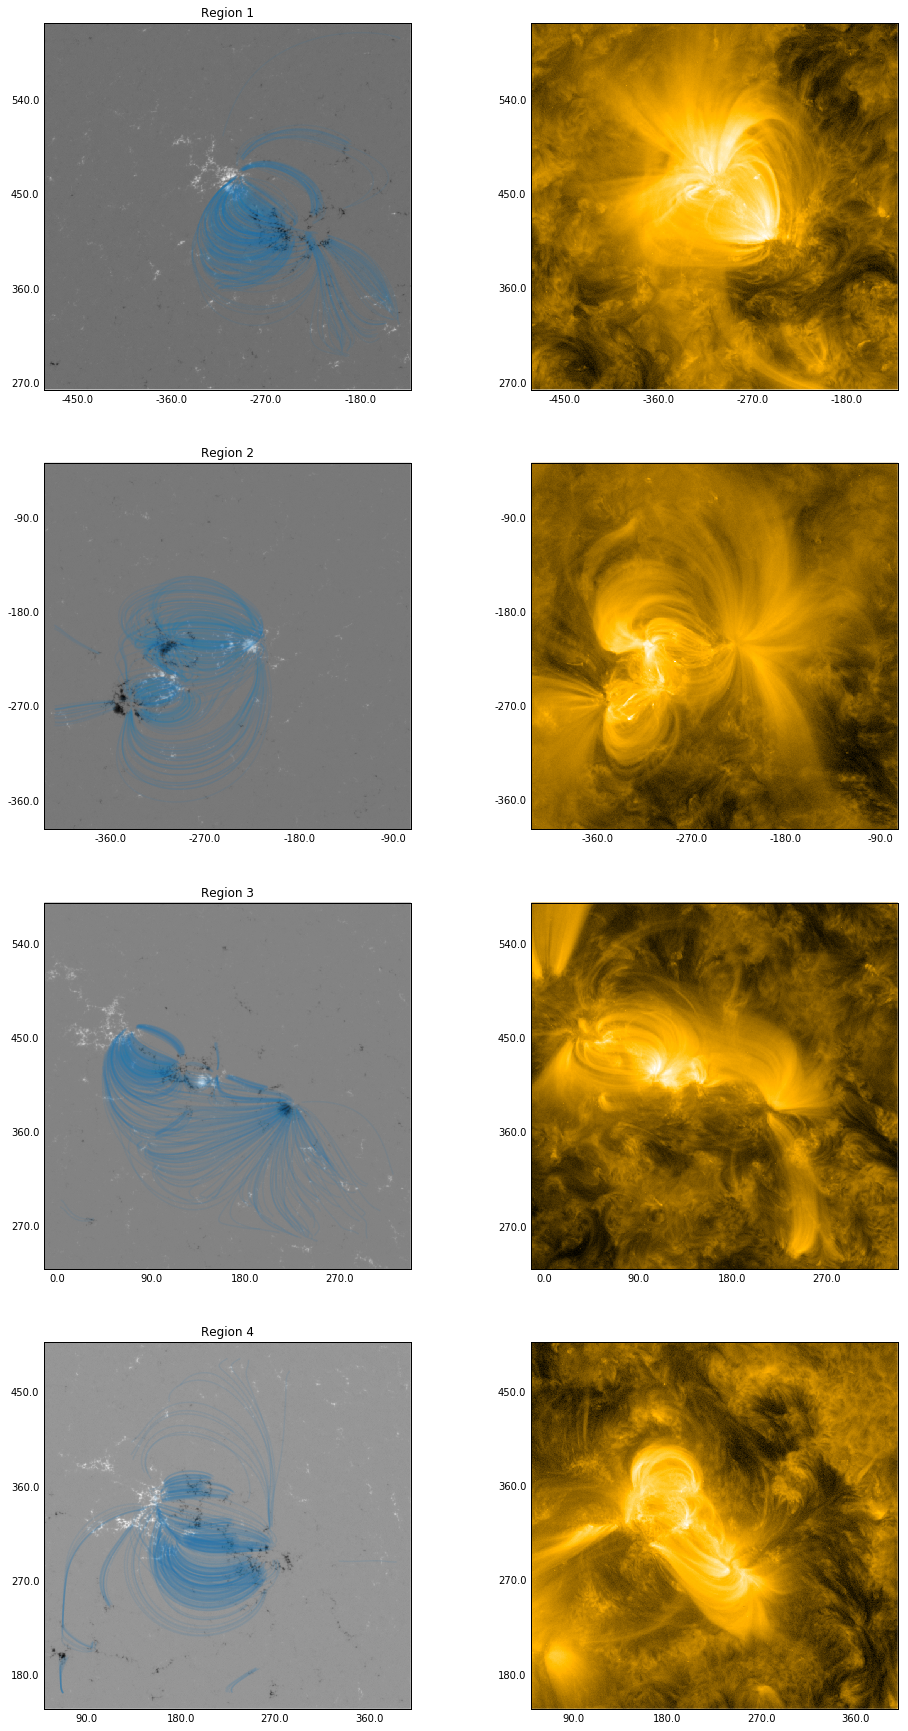

In [25]:
img_width = 8
fig = plt.figure(figsize=(img_width*2,img_width*15))
for i,(row,field) in enumerate(zip(ar_catalogue[:4],skeleton_list[:4])):
    print('Plotting Region {}'.format(row['Region']))
    ### HMI ###
    tmp_map = Map(row['HMI File'])
    tmp_map = tmp_map.rotate()
    blc = SkyCoord(row['X_cen']-width/2, row['Y_cen']-height/2, frame = tmp_map.coordinate_frame)
    trc = SkyCoord(row['X_cen']+width/2, row['Y_cen']+height/2, frame = tmp_map.coordinate_frame)
    tmp_map = tmp_map.submap(blc, trc)
    ax = fig.add_subplot(15,2,2*i+1,projection=tmp_map)
    tmp_map.plot(axes=ax,annotate=False)
    ax.coords[0].grid(alpha=0)
    ax.coords[1].grid(alpha=0)
    ax.set_title('Region {}'.format(row['Region']))
    # plot streamlines
    if hasattr(field,'streamlines'):
        for stream, _ in field.streamlines:
            ax.plot(field._convert_angle_to_length(stream[:, 0]*u.cm,working_units=u.arcsec).to(u.deg),
                    field._convert_angle_to_length(stream[:, 1]*u.cm,working_units=u.arcsec).to(u.deg),
                    alpha=0.1,color=sns.color_palette()[0],transform=ax.get_transform('world'))

    ### AIA ###
    tmp_map = Map(row['AIA File'])
    blc = SkyCoord(row['X_cen']-width/2, row['Y_cen']-height/2, frame = tmp_map.coordinate_frame)
    trc = SkyCoord(row['X_cen']+width/2, row['Y_cen']+height/2, frame = tmp_map.coordinate_frame)
    tmp_map = tmp_map.submap(blc, trc)
    ax = fig.add_subplot(15,2,2*(i+1),projection=tmp_map)
    tmp_map.plot(axes=ax,annotate=False,)
    ax.coords[0].grid(alpha=0)
    ax.coords[1].grid(alpha=0)

We can also visualize the extrapolated field with `yt`. Let's try these for each of our regions and overplot some fieldlines on top.

yt : [INFO     ] 2017-12-01 16:04:50,449 Projection completed
yt : [INFO     ] 2017-12-01 16:04:50,450 xlim = -34108034187.215740 -10145379868.855732
yt : [INFO     ] 2017-12-01 16:04:50,450 ylim = 20609656241.730545 44914634193.209969
yt : [INFO     ] 2017-12-01 16:04:50,451 xlim = -34108034187.215740 -10145379868.855732
yt : [INFO     ] 2017-12-01 16:04:50,452 ylim = 20609656241.730545 44914634193.209969
yt : [INFO     ] 2017-12-01 16:04:50,453 Making a fixed resolution buffer of (('stream', 'Bx')) 800 by 800
yt : [INFO     ] 2017-12-01 16:04:50,462 Making a fixed resolution buffer of (('stream', 'By')) 800 by 800
yt : [INFO     ] 2017-12-01 16:04:50,471 Making a fixed resolution buffer of (('stream', 'Bz')) 800 by 800
yt : [WARNING  ] 2017-12-01 16:04:50,492 Plot image for field ('stream', 'By') has both positive and negative values. Min = -61329222.732439, Max = 34438366.697641.
yt : [WARNING  ] 2017-12-01 16:04:50,492 Switching to symlog colorbar scaling unless linear scaling is s

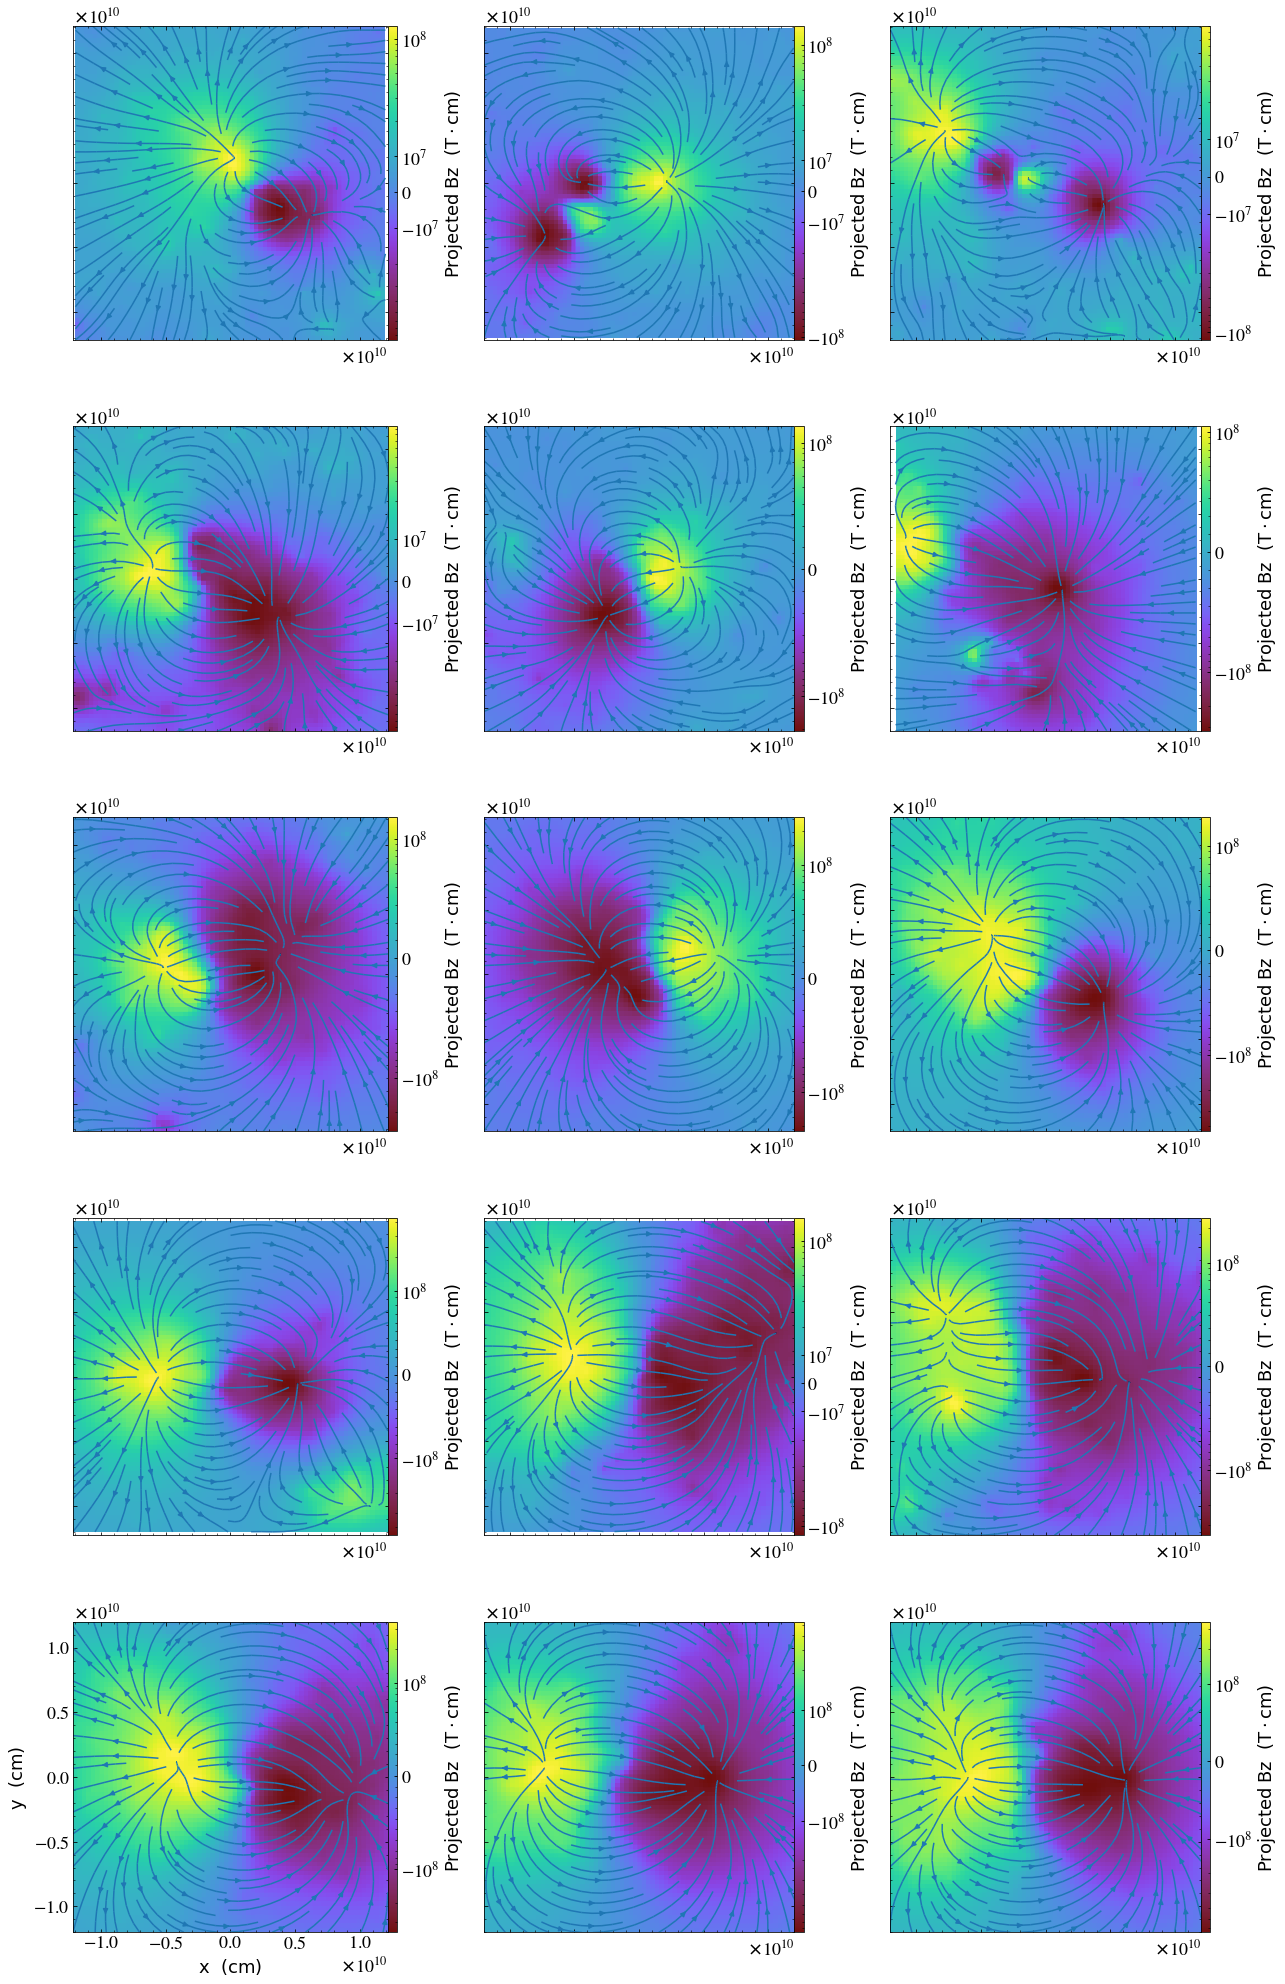

In [26]:
mag_fields = ['Bx','By','Bz']
fig = plt.figure()
grid = AxesGrid(fig, (0.075,0.075,0.85,0.85),
                nrows_ncols = (5, 3),
                axes_pad = 1.2,
                label_mode = "1",
                share_all = False,
                cbar_location="right",
                cbar_mode="each",
                cbar_size="3%",
                cbar_pad="0%")
fig.set_figwidth(25)
for i,field in enumerate(skeleton_list):
    p = yt.ProjectionPlot(field.extrapolated_3d_field,'z',mag_fields,origin='center-domain',axes_unit='cm')
    p.annotate_streamlines('Bx','By')
    p.figure_size = 30
    plot = p.plots['Bz']
    plot.figure = fig
    plot.axes = grid[i].axes
    plot.cax = grid.cbar_axes[i]
    p._setup_plots()

## Zooming In
After looking over several of the extrapolated fields and comparing with the 171 Å intensity, we've selected a subset of the ARs: 1,2,3,5,9,10. We now want to adjust the FOV for each of these, increase the number of fieldlines we trace through the volume, and compare with the 193 Å intensity as well.

In [ ]:
first_round_picks = ar_catalogue[(ar_catalogue['Region'] == '1') 
                                   | (ar_catalogue['Region'] == '2')
                                   | (ar_catalogue['Region'] == '3') 
                                   | (ar_catalogue['Region'] == '5')
                                   | (ar_catalogue['Region'] == '9')
                                   | (ar_catalogue['Region'] == '10')
                                ]

In [ ]:
first_round_picks

In [ ]:
aia_193_files = []

In [ ]:
for row in first_round_picks:
    print('Querying data for region #{}'.format(row['Region']))
    # query
    ### AIA
    dt = 10
    start_time = convert_npdt_to_str(row['Date'] - np.timedelta64(dt,'s'))
    end_time = convert_npdt_to_str(row['Date'] + np.timedelta64(dt,'s'))
    q_aia_193 = client.query(
        vso.attrs.Time(start_time,end_time),
        vso.attrs.Instrument('AIA'),
        vso.attrs.Wave(193*u.angstrom,193*u.angstrom)
    )
    print(q_aia_193)
    aia_193_res = client.get(q_aia_193,path=os.path.join(obs_data_loc,'{file}')).wait()
    aia_193_files.append(aia_193_res[0])

In [ ]:
first_round_picks['AIA File'].name =  'AIA 171 File'
first_round_picks['AIA 193 File'] = aia_193_files

Refine FOV selection. Expand and recenter the regions of opposite polarity. Make sure there is enough room on the outside for the loops.

In [ ]:
resample_resolution = u.Quantity([100,100]*u.pixel)
zshape = 100
number_of_lines = 1000

In [ ]:
first_round_picks['X range'] = [
    u.Quantity([-420,-170],u.arcsec),
    u.Quantity([-400,-190],u.arcsec),
    u.Quantity([0,350],u.arcsec),
    u.Quantity([-600,-375],u.arcsec),
    u.Quantity([125,575],u.arcsec),
    u.Quantity([-150,250],u.arcsec)
]
first_round_picks['X range'].unit = u.arcsec
first_round_picks['Y range'] = [
    u.Quantity([320,570],u.arcsec),
    u.Quantity([-335,-125],u.arcsec),
    u.Quantity([230,580],u.arcsec),
    u.Quantity([-375,-150],u.arcsec),
    u.Quantity([50,500],u.arcsec),
    u.Quantity([150,550],u.arcsec)
]
first_round_picks['Y range'].unit = u.arcsec

In [ ]:
first_round_picks[1]['Y range']

Do the field extrapolations.

In [ ]:
first_round_skeletons = []

In [ ]:
for row in first_round_picks[3:]:
    print('Extrapolating field for region {}'.format(row['Region']))
    field = synthesizAR.Skeleton(hmi_fits_file=row['HMI File'],
                                 crop=(row['X range'],row['Y range']),
                                 resample=resample_resolution)
    delta_x = np.diff(row['X range'])[0]
    delta_y = np.diff(row['Y range'])[0]
    field.extrapolate_field(zshape=zshape,
                            zrange=u.Quantity([-10.*u.arcsec,max(delta_x,delta_y)]))
    field.extract_streamlines(number_of_lines)
    first_round_skeletons.append(field)

Finally, plot everything again.

In [ ]:
img_width = 8
fig = plt.figure(figsize=(img_width*3,img_width*6))
for i,(row,field) in enumerate(zip(first_round_picks,first_round_skeletons)):
    print('Plotting Region {}'.format(row['Region']))
    ### HMI ###
    tmp_map = Map(row['HMI File'])
    tmp_map = tmp_map.rotate()
    tmp_map = tmp_map.submap(row['X range'],row['Y range'])
    ax = fig.add_subplot(6,3,3*i+1,projection=tmp_map)
    tmp_map.plot(axes=ax,annotate=False)
    ax.coords[0].grid(alpha=0)
    ax.coords[1].grid(alpha=0)
    ax.set_title('SDO/HMI LOS Magnetogram')
    # plot streamlines
    for stream, _ in field.streamlines:
        ax.plot(field._convert_angle_to_length(stream[:, 0]*u.cm,working_units=u.arcsec).to(u.deg),
                field._convert_angle_to_length(stream[:, 1]*u.cm,working_units=u.arcsec).to(u.deg),
                alpha=0.2,color=sns.color_palette()[0],transform=ax.get_transform('world'))

    ### AIA ###
    # 171
    tmp_map = Map(row['AIA 171 File'])
    tmp_map = tmp_map.submap(row['X range'],row['Y range'])
    ax = fig.add_subplot(6,3,3*i+2,projection=tmp_map)
    tmp_map.plot(axes=ax,annotate=False,)
    ax.coords[0].grid(alpha=0)
    ax.coords[1].grid(alpha=0)
    ax.set_title('Region {}, NOAA {}\nSDO/AIA 171 Å'.format(row['Region'],row['NOAA']))
    # 193
    tmp_map = Map(row['AIA 193 File'])
    tmp_map = tmp_map.submap(row['X range'],row['Y range'])
    ax = fig.add_subplot(6,3,3*(i+1),projection=tmp_map)
    tmp_map.plot(axes=ax,annotate=False,)
    ax.coords[0].grid(alpha=0)
    ax.coords[1].grid(alpha=0)
    ax.set_title('SDO/AIA 193 Å')

In [ ]:
# plot streamlines
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
for stream, _ in first_round_skeletons[1].streamlines:
    ax.plot(stream[:, 1],stream[:, 2],alpha=0.1,color=sns.color_palette()[0])
ax.set_ylim([0,5.5e9])
ax.set_xlim([-1.8e10,-1.4e10])